In [40]:
import ast
import random

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# how many attestations to create in the test data
n_edges = 100

# how many nodes should receive a pre-weighting before the reputation algorithm runs?
# they are used to pre-weight nodes in pagerank scoring.
n_prior = 50

# the damping factor for pagerank.  
# this is the probability that the random surfer continues clicking hyperlinks rather than jumping randomly.
damping = 0.8

with open('data_in/test_response_2.json', 'r') as f:
    att_list = ast.literal_eval(f.read())

df = pd.DataFrame(columns=['attester_of_truth', 'self_attester', 'attestation'])
for att_bundle in att_list:
    for att in att_bundle['attestation']:
        df.loc[len(df.index)] = [att['attestor_of_truth'], att_bundle['getAttestation']['selfAttestor'], att['attestation']]
df

df1 = df[['attester_of_truth']].rename(columns={'attester_of_truth':'addr'})
df2 = df[['self_attester']].rename(columns={'self_attester':'addr'})
df_addr = pd.concat([df1, df2])
df_addr.head()

# a pandas series of addresses to receive a preweight.
# these entities have verified their identity and some offchain data to receive a pre-existing reputation score
ser_prior_addr = df_addr.sample(n_prior).values

# randomly assign the preweights for test data
ser_prior_val = [.1 * random.randint(1,10) for i in range(len(ser_prior_addr))]

# convert to dataframe
df_priors = pd.DataFrame({'addr': ser_prior_addr.flatten() , 'score':ser_prior_val})
dict_priors = {x:y for x,y in zip(ser_prior_addr.flatten() , ser_prior_val)}
df_priors.head()

# append a column with the priors and write out to csv
df_addr = df_addr.merge(df_priors, on='addr', how='left')
df_addr = df_addr.fillna(0)
df_addr.to_csv('data_out/priors.csv')
df_addr.head()

# based on the priors, compute the score of each attestation
df_tmp = df.copy()
df_tmp['attester_of_truth_rep'] = df_tmp["attester_of_truth"].map(dict_priors)
df_tmp = df_tmp[df_tmp.attester_of_truth_rep > 0]
df_tmp.head()

# score the attestations
df_tmp_group = df_tmp[['self_attester', 'attestation', 'attester_of_truth_rep']].groupby(by=['self_attester', 'attestation']).max()
df_attestation_scores = df_tmp_group.reset_index().rename(columns={'self_attester':'addr', 'attester_of_truth_rep':'attestation_score'})
df_attestation_scores.sort_values(['addr', 'attestation_score'], inplace=True)
df_attestation_scores.to_csv('data_out/attestation_scores_from_priors.csv')
df_attestation_scores.head()

# update the priors with the minimum of the self_attestation scores
df_tmp = df_tmp_group = None
df_tmp = df_attestation_scores[['addr', 'attestation_score']].groupby(by=['addr']).max()
df_tmp = df_tmp.reset_index().rename(columns={'attestation_score':'score'})
df_tmp = pd.concat([df_tmp, df_priors])
df_tmp_group = df_tmp.groupby(by=['addr']).min()
df_updated_priors = df_tmp_group.reset_index()
df_updated_priors.to_csv('data_out/updated_priors.csv')
dict_updated_priors = {x:y for x,y in zip(df_updated_priors.addr , df_updated_priors.score)}
df_updated_priors.head()

# the attribution graph, as a networkx object
att_graph = nx.from_pandas_edgelist(df, source="attester_of_truth", target="self_attester", create_using=nx.DiGraph())

# the "personalization" vector ("personalization" is the pagerank term).
# this determines the ranking of nodes in a random jump due to the damping constant, which amounts to a kind of node weighting.
# the personalization vector for this application is the prescores based on (hypothetical) real-world data
personalization_vector = {A: B for A, B in zip(df_addr['addr'], df_addr['score'])}

# run pagerank
pg_scores = nx.pagerank(att_graph, alpha=damping, personalization=personalization_vector)

# copy the dataframe with priors so that we can replace the priors with reputation scores from pagerank
df_score = df_addr.copy()
df_score['score'] = df_score["addr"].map(pg_scores).fillna(0)

df_score.to_csv('data_out/addr_pageranks.csv')

df_score

TypeError: string indices must be integers, not 'str'

In [33]:
# visualize the graph for qualitative assessment

def render_social_graph(df, score_dict, prior_dict):
    # dials to adjust the rgb values of nodes in the graph
    brightness_multiplier_blue = 20
    brightness_multiplier_green = 1
    brightness_blue = 1
    brightness_green = 0.8
    brightness_divisor = 2

    G = nx.DiGraph()
    G.add_nodes_from(df['attester_of_truth'])
    G.add_nodes_from(df['self_attester'])
    edges = [(row['attester_of_truth'], row['self_attester']) for index, row in df.iterrows()]
    G.add_edges_from(edges)

    color_map = []
    for node in G:
        
        reputation_score = score_dict[node] if node in score_dict else 0
    
        # color nodes darker for higher pagerank. 
        # color nodes green if they have a prescore
        if node in prior_dict:
            max_brightness = brightness_green / brightness_divisor
            brightness = max_brightness  - min(reputation_score * brightness_multiplier_green, max_brightness)
            color_map.append((brightness, brightness_green, brightness))
        else:
            max_brightness = brightness_blue / brightness_divisor
            brightness = max_brightness - min(reputation_score * brightness_multiplier_blue, max_brightness)
            color_map.append((brightness, brightness, brightness_blue))
        
    # see https://networkx.org/documentation/stable/reference/drawing.html
    # this layout can be replaced for better visualization
    pos = nx.spring_layout(G) 

    nx.draw_networkx(G, pos, with_labels=False, arrows=True, node_size=30, node_color=color_map, font_size=10, font_color='black')
    plt.show()

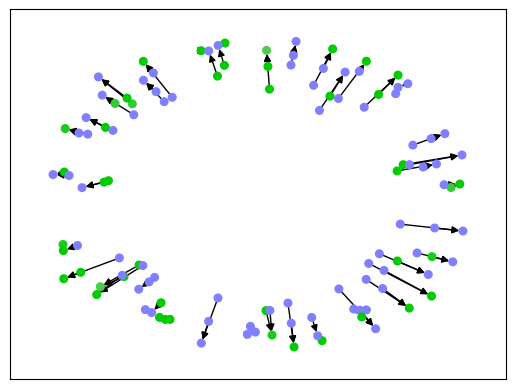

In [27]:
# 
render_social_graph(df, dict_priors, dict_priors)

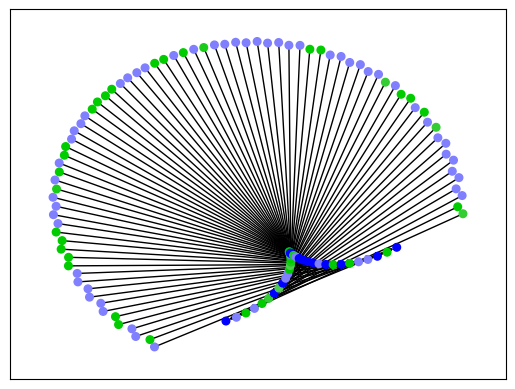

In [17]:
render_social_graph(df, dict_updated_priors, dict_priors)

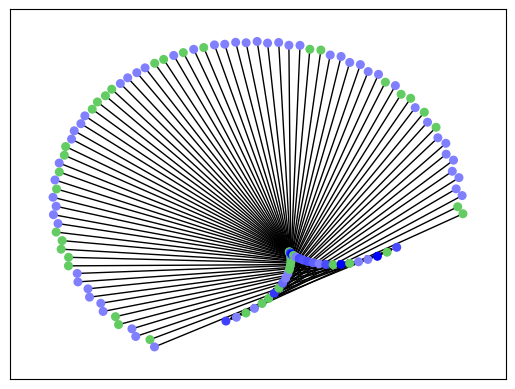

In [18]:
render_social_graph(df, pg_scores, dict_priors)

## Harpie

In [47]:
import requests
import json

def check_address(address):
    url = "https://api.harpie.io/v2/validateAddress"
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }
    data = {
        'apiKey': 'd90dd5df-8a5b-44e5-a419-b754431ea614',
        'address': address
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    isMaliciousAddress = response.json()['isMaliciousAddress']

    return isMaliciousAddress


In [48]:
check_address("0x55456cbd1f11298b80a53c896f4b1dc9bc16c731")

True

In [49]:
addresses = df_score.addr.unique()

In [50]:
results = {}
for address in addresses:
    results[address] = check_address(address)

In [51]:
results

{'0x0c003e23c789028cec14c804796f6b4f4ffab1e9': False,
 '0x060d3ce179dff8a688f010dab52c54f30283fc61': False,
 '0x00003e23c789028cec14c804796f6b4f4ffab1e9': False,
 '0x000d3ce179dff8a688f010dab52c54f30283fc61': False,
 '0x00103e23c789028cec14c804796f6b4f4ffab1e9': False,
 '0x001d3ce179dff8a688f010dab52c54f30283fc61': False,
 '0x00113e23c789028cec14c804796f6b4f4ffab1e9': False,
 '0x00103ce179dff8a688f010dab52c54f30283fc61': False,
 '0x00110e23c789028cec14c804796f6b4f4ffab1e9': False,
 '0x00100ce179dff8a688f010dab52c54f30283fc61': False,
 '0x00110023c789028cec14c804796f6b4f4ffab1e9': False,
 '0x001000e179dff8a688f010dab52c54f30283fc61': False,
 '0x00110003c789028cec14c804796f6b4f4ffab1e9': False,
 '0x0010000179dff8a688f010dab52c54f30283fc61': False,
 '0x00110000c789028cec14c804796f6b4f4ffab1e9': False,
 '0x0010000079dff8a688f010dab52c54f30283fc61': False,
 '0x001100000789028cec14c804796f6b4f4ffab1e9': False,
 '0x0010000009dff8a688f010dab52c54f30283fc61': False,
 '0x001100000089028cec14c804